# House Price Prediction Comparison: Keras/TensorFlow, PyTorch, and JAX

This notebook implements three versions of a neural network to predict house prices. In all three implementations we:

- Load and preprocess the data (with missing-value imputation, one-hot encoding, and a log transformation of the target SalePrice).
- Perform feature selection using the correlation matrix (selecting the top five features most correlated with SalePrice).
- Split the data into training (80%) and validation (20%) sets and scale the features.
- Build a neural network that minimizes a combined loss: the MSE (on log-transformed SalePrice) plus a KL divergence penalty (computed from differentiable soft histograms).
- Train the model and then evaluate by computing RMSE (after exponentiating predictions) and plotting loss curves and distribution histograms.

Finally, summary plots compare performance (loss curves, RMSE, and predicted vs. actual distributions) for the three frameworks.

**Note:** Update the file paths before running.

In [1]:
pip install pytorch

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-c24migmk/pytorch_ecff133958344fe0833e5867c5631bbf/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pyto

In [2]:
pip install tensorflow


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install jax


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install flax


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# JAX / Flax / Optax
import jax
import jax.numpy as jnp
import flax.linen as nn_flax
from flax.training import train_state
import optax

print('TensorFlow version:', tf.__version__)
print('Torch version:', torch.__version__)
print('JAX version:', jax.__version__)

%matplotlib inline

2025-02-25 04:11:11.511745: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 04:11:11.515611: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 04:11:11.525343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740456671.553971   10382 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740456671.561519   10382 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 04:11:11.587648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

TensorFlow version: 2.18.0
Torch version: 2.5.1+cpu
JAX version: 0.5.0


## 1. Load and Preprocess Data

Update the following paths to your `train.csv` and `test.csv` files.

In [6]:
# Update these paths
train_path = 'train.csv'
test_path = 'test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (1000, 81)
Test shape: (460, 80)


### 1.1 Preprocessing & Target Transformation

Fill missing values (numeric columns with median, categorical columns with mode), one-hot encode categorical features, drop the `Id` column, and apply a log transformation to the target (`SalePrice`).

Processed training features shape: (1000, 230)


/tmp/ipykernel_10382/2818284174.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_10382/2818284174.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

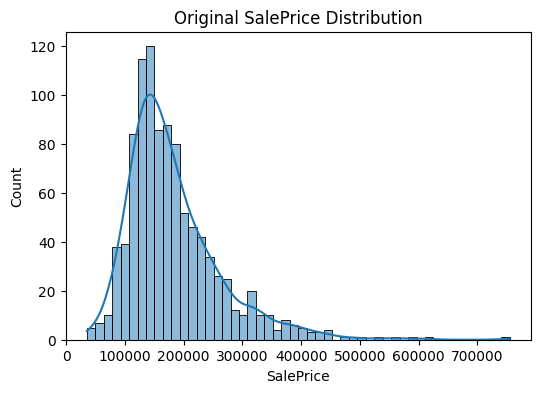

In [7]:
def fill_missing_values(df):
    # Fill numeric columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    # Fill categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

# Process training data
train_df = fill_missing_values(train_df.copy())

# Save and drop Id
train_ids = train_df['Id']
train_df.drop('Id', axis=1, inplace=True)

# Apply log transformation on target
y = np.log(train_df['SalePrice'])
X = train_df.drop('SalePrice', axis=1)

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

print('Processed training features shape:', X.shape)

# (Optionally, inspect distribution)
plt.figure(figsize=(6,4))
sns.histplot(np.exp(y), bins=50, kde=True)
plt.title('Original SalePrice Distribution')
plt.xlabel('SalePrice')
plt.show()

### 1.2 Feature Selection

Compute the correlation matrix (on numeric columns) and select the top five features most correlated with SalePrice.

In [8]:
numeric_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).iloc[1:6].index.tolist()
print('Top 5 features selected:', top_features)

# Update X to keep only these features
X = X[top_features]
print('X shape after feature selection:', X.shape)

Top 5 features selected: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
X shape after feature selection: (1000, 5)


### 1.3 Train-Validation Split and Scaling

Split the data (80% train, 20% validation) and scale the features.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_val_scaled shape:', X_val_scaled.shape)

X_train_scaled shape: (800, 5)
X_val_scaled shape: (200, 5)


## 2. Keras/TensorFlow Implementation

We define a model in Keras with a combined loss that adds MSE and a KL divergence penalty (computed on soft histograms of log(SalePrice)).

In [10]:
def soft_histogram_tf(x, bin_centers, sigma):
    x = tf.reshape(x, [-1, 1])
    diff = x - bin_centers
    soft_counts = tf.exp(-tf.square(diff) / (2.0 * sigma**2))
    hist = tf.reduce_sum(soft_counts, axis=0)
    hist = hist / tf.reduce_sum(hist)
    return hist

def kl_divergence_loss_tf(y_true, y_pred, num_bins=50, sigma=1.0):
    min_val = tf.reduce_min(y_true)
    max_val = tf.reduce_max(y_true)
    bin_centers = tf.linspace(min_val, max_val, num_bins)
    hist_true = soft_histogram_tf(y_true, bin_centers, sigma)
    hist_pred = soft_histogram_tf(y_pred, bin_centers, sigma)
    epsilon = 1e-6
    hist_true = tf.clip_by_value(hist_true, epsilon, 1.0)
    hist_pred = tf.clip_by_value(hist_pred, epsilon, 1.0)
    kl_loss = tf.reduce_sum(hist_true * tf.math.log(hist_true / hist_pred))
    tf.print("KL loss:", kl_loss, "hist_true:", hist_true, "hist_pred:", hist_pred)
    tf.debugging.check_numerics(kl_loss, message="KL divergence loss produced NaN")
    return kl_loss

def combined_loss_tf(y_true, y_pred, alpha=0.001):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    kl_loss = kl_divergence_loss_tf(y_true, y_pred, num_bins=50, sigma=1.0)
    total_loss = mse_loss + alpha * kl_loss
    tf.debugging.check_numerics(total_loss, message="Combined loss produced NaN")
    return total_loss

# Build and compile the Keras model
model_keras = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model_keras.compile(optimizer='adam', loss=lambda y_true, y_pred: combined_loss_tf(y_true, y_pred, alpha=0.001))
model_keras.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-25 04:11:18.852827: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train Keras Model
Train the Keras model and record the history.

In [11]:
history_keras = model_keras.fit(X_train_scaled, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_scaled, y_val),
                    verbose=1)

Epoch 1/50
KL loss: 7.44888 hist_true: [0.00970947184 0.0102758631 0.0108569488 ... 0.0199542362 0.0193671677 0.0187608153] hist_pred: [0.388355315 0.238382816 0.145991266 ... 1e-06 1e-06 1e-06]
 1/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 148.8772KL loss: 5.98942423 hist_true: [0.0189512726 0.0194419622 0.0199146047 ... 0.0125043392 0.0119780088 0.0114586987] hist_pred: [0.369624019 0.233689591 0.147488266 ... 1e-06 1e-06 1e-06]
KL loss: 6.17948914 hist_true: [0.0192890074 0.0198558513 0.020402154 ... 0.0109346686 0.01036721 0.00981344841] hist_pred: [0.395816803 0.239902422 0.14509885 ... 1e-06 1e-06 1e-06]
KL loss: 5.36382389 hist_true: [0.0172552988 0.0176206976 0.0179767031 ... 0.0167127959 0.0163333025 0.0159477722] hist_pred: [0.296306491 0.209042832 0.147318587 ... 1e-06 1e-06 1e-06]
KL loss: 5.57921791 hist_true: [0.0170671139 0.0174756162 0.0178743843 ... 0.0160211809 0.0155897252 0.0151536027] hist_pred: [0.311855167 0.215164602 0.148275152 ... 1e-06 1e-06 1e-06]
KL loss: 

### Evaluate Keras Model
Obtain predictions (on log scale) and compute RMSE after exponentiating. Also, plot loss curves and distribution histograms.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Any NaNs in Keras predictions? False
Keras Validation RMSE: 431797.7582114109


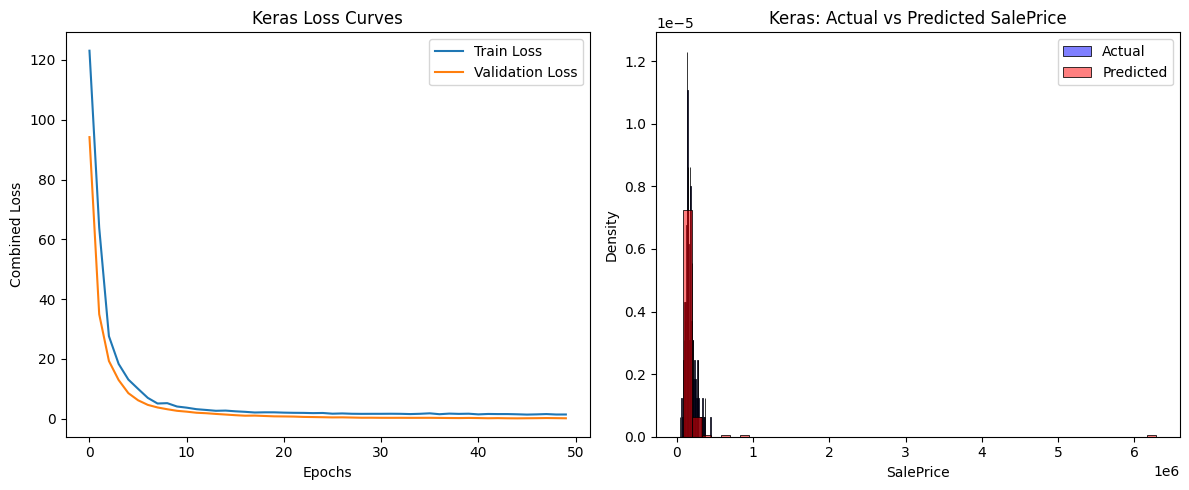

In [14]:
# Predict on validation set (log scale)
y_val_pred_log = model_keras.predict(X_val_scaled).flatten()
print("Any NaNs in Keras predictions?", np.any(np.isnan(y_val_pred_log)))

# Convert predictions back to original scale
y_val_pred = np.exp(y_val_pred_log)
y_val_actual = np.exp(y_val)  
rmse_keras = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
print('Keras Validation RMSE:', rmse_keras)

# Plot loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_keras.history['loss'], label='Train Loss')
plt.plot(history_keras.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Combined Loss')
plt.title('Keras Loss Curves')
plt.legend()

# Plot distribution histograms
plt.subplot(1,2,2)
sns.histplot(y_val_actual, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(y_val_pred, bins=50, color='red', alpha=0.5, stat='density', label='Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Keras: Actual vs Predicted SalePrice')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# --- Keras Prediction Saving Cell ---
# Preprocess test data as for training
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
# Reindex to ensure the same columns as used in training
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)

# Get predictions (on log scale) and convert back to original scale
preds_keras_log = model_keras.predict(test_scaled).flatten()
preds_keras = np.exp(preds_keras_log)

# Save predictions
predictions_keras = pd.DataFrame({'ID': test_ids, 'SALEPRICE': preds_keras})
predictions_keras.to_csv('predictions_keras_KL.csv', index=False)
print("Keras predictions saved to predictions_keras_KL.csv")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Keras predictions saved to predictions_keras_KL.csv


/tmp/ipykernel_10382/2818284174.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_10382/2818284174.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

## 3. PyTorch Implementation
We now build and train a PyTorch model with a similar combined loss function.

In [17]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
def soft_histogram_torch(x, bin_centers, sigma):
    # x: tensor of shape (batch, 1)
    x = x.view(-1, 1)
    bin_centers = bin_centers.view(1, -1)
    diff = x - bin_centers
    soft_counts = torch.exp(- (diff ** 2) / (2 * sigma ** 2))
    hist = torch.sum(soft_counts, dim=0)
    hist = hist / torch.sum(hist)
    return hist

def kl_divergence_loss_torch(y_true, y_pred, num_bins=50, sigma=1.0):
    min_val = torch.min(y_true)
    max_val = torch.max(y_true)
    bin_centers = torch.linspace(min_val, max_val, steps=num_bins, device=y_true.device)
    hist_true = soft_histogram_torch(y_true, bin_centers, sigma)
    hist_pred = soft_histogram_torch(y_pred, bin_centers, sigma)
    epsilon = 1e-6
    hist_true = torch.clamp(hist_true, min=epsilon, max=1.0)
    hist_pred = torch.clamp(hist_pred, min=epsilon, max=1.0)
    kl = torch.sum(hist_true * torch.log(hist_true / hist_pred))
    return kl

def combined_loss_torch(y_true, y_pred, alpha=0.001):
    mse = torch.mean((y_true - y_pred) ** 2)
    kl = kl_divergence_loss_torch(y_true, y_pred, num_bins=50, sigma=1.0)
    return mse + alpha * kl

# Build the PyTorch model (log-transformed target)
class HousePriceNetTorch(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceNetTorch, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

input_dim_pt = X_train_scaled.shape[1]
model_torch = HousePriceNetTorch(input_dim_pt).to(device)
print(model_torch)

HousePriceNetTorch(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


### Train PyTorch Model
We convert data to tensors, train for 50 epochs, and record training losses.

In [19]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

optimizer_torch = optim.Adam(model_torch.parameters(), lr=0.001)
num_epochs_pt = 50
train_losses_pt = []
val_losses_pt = []

for epoch in range(num_epochs_pt):
    model_torch.train()
    optimizer_torch.zero_grad()
    outputs = model_torch(X_train_tensor)
    loss = combined_loss_torch(y_train_tensor, outputs, alpha=0.001)
    loss.backward()
    optimizer_torch.step()
    train_losses_pt.append(loss.item())
    
    model_torch.eval()
    with torch.no_grad():
        val_outputs = model_torch(X_val_tensor)
        val_loss = combined_loss_torch(y_val_tensor, val_outputs, alpha=0.001)
        val_losses_pt.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        rmse_val = np.sqrt(mean_squared_error(y_val_tensor.cpu().numpy(), val_outputs.cpu().numpy()))
        print(f"Epoch {epoch+1}/{num_epochs_pt}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val RMSE: {rmse_val:.4f}")

Epoch 10/50, Train Loss: 131.5988, Val Loss: 129.5213, Val RMSE: 11.3804
Epoch 20/50, Train Loss: 111.4215, Val Loss: 109.2262, Val RMSE: 10.4509
Epoch 30/50, Train Loss: 85.2943, Val Loss: 83.2432, Val RMSE: 9.1236
Epoch 40/50, Train Loss: 56.9735, Val Loss: 55.2123, Val RMSE: 7.4305
Epoch 50/50, Train Loss: 35.3182, Val Loss: 32.5808, Val RMSE: 5.7080


### Evaluate PyTorch Model
Obtain predictions on the validation set, convert from log scale, and compute RMSE. Also, plot distributions.

Any NaNs in PyTorch predictions? False
PyTorch Validation RMSE: 5861882.968990766


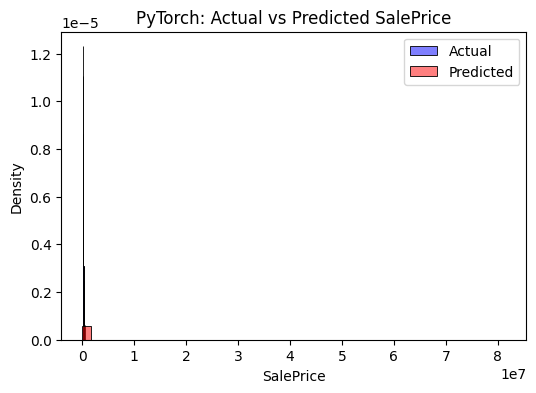

In [20]:
model_torch.eval()
with torch.no_grad():
    val_preds_pt_log = model_torch(X_val_tensor).cpu().numpy().flatten()

print("Any NaNs in PyTorch predictions?", np.any(np.isnan(val_preds_pt_log)))

# Convert predictions back to original scale
val_preds_pt = np.exp(val_preds_pt_log)
y_val_actual_pt = np.exp(y_val_tensor.cpu().numpy().flatten())
rmse_torch = np.sqrt(mean_squared_error(y_val_actual_pt, val_preds_pt))
print('PyTorch Validation RMSE:', rmse_torch)

# Plot distribution histograms for PyTorch
plt.figure(figsize=(6,4))
sns.histplot(y_val_actual_pt, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(val_preds_pt, bins=50, color='red', alpha=0.5, stat='density', label='Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('PyTorch: Actual vs Predicted SalePrice')
plt.legend()
plt.show()

In [21]:
# --- PyTorch Prediction Saving Cell ---
# Ensure device is defined:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocess test data as done for training
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32).to(device)

# Set model to evaluation mode and get predictions (on log scale)
model_torch.eval()
with torch.no_grad():
    preds_torch_log = model_torch(test_tensor).cpu().numpy().flatten()

# Convert predictions back to original scale
preds_torch = np.exp(preds_torch_log)

# Save predictions
predictions_torch = pd.DataFrame({'ID': test_ids, 'SALEPRICE': preds_torch})
predictions_torch.to_csv('predictions_pytorch_KL.csv', index=False)
print("PyTorch predictions saved to predictions_pytorch_KL.csv")


PyTorch predictions saved to predictions_pytorch_KL.csv


/tmp/ipykernel_10382/2818284174.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_10382/2818284174.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

## 4. JAX (Flax & Optax) Implementation
We now implement the model using JAX with Flax and Optax. The combined loss function is similar to before.

In [22]:
class HousePriceNetJAX(nn_flax.Module):
    dropout_rate: float = 0.2
    
    @nn_flax.compact
    def __call__(self, x, training):
        x = nn_flax.Dense(128)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(64)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(1)(x)
        return x

model_jax = HousePriceNetJAX()
rng_jax = jax.random.PRNGKey(0)
dummy_input = jnp.ones((X_train_scaled.shape[0], X_train_scaled.shape[1]))
params_jax = model_jax.init(rng_jax, dummy_input, training=True)['params']
print('JAX model parameters initialized.')

JAX model parameters initialized.


### Define Training State and Combined Loss in JAX
We define a differentiable soft histogram and compute KL divergence on the log-transformed values.

In [23]:
class TrainState(train_state.TrainState):
    pass

def soft_histogram_jax(x, bin_centers, sigma):
    x = jnp.reshape(x, (-1, 1))
    diff = x - bin_centers  # (batch, num_bins)
    soft_counts = jnp.exp(- (diff ** 2) / (2 * sigma ** 2))
    hist = jnp.sum(soft_counts, axis=0)
    hist = hist / jnp.sum(hist)
    return hist

def kl_divergence_loss_jax(params, batch, rng, training, num_bins=50, sigma=1.0):
    inputs, targets = batch
    preds = model_jax.apply({'params': params}, inputs, training=training, rngs={'dropout': rng})
    min_val = jnp.min(targets)
    max_val = jnp.max(targets)
    bin_centers = jnp.linspace(min_val, max_val, num_bins)
    hist_true = soft_histogram_jax(jnp.ravel(targets), bin_centers, sigma)
    hist_pred = soft_histogram_jax(jnp.ravel(preds), bin_centers, sigma)
    epsilon = 1e-6
    hist_true = jnp.clip(hist_true, epsilon, 1.0)
    hist_pred = jnp.clip(hist_pred, epsilon, 1.0)
    kl = jnp.sum(hist_true * jnp.log(hist_true / hist_pred))
    return kl

def mse_loss_jax(params, batch, rng, training):
    inputs, targets = batch
    preds = model_jax.apply({'params': params}, inputs, training=training, rngs={'dropout': rng})
    return jnp.mean((preds - targets) ** 2)

def combined_loss_jax(params, batch, rng, training, alpha=0.001):
    mse = mse_loss_jax(params, batch, rng, training)
    kl = kl_divergence_loss_jax(params, batch, rng, training, num_bins=50, sigma=1.0)
    return mse + alpha * kl

learning_rate = 0.001
tx = optax.adam(learning_rate)
state_jax = TrainState.create(apply_fn=model_jax.apply, params=params_jax, tx=tx)
print('JAX training state created.')

JAX training state created.


### Train JAX Model
Train the model for 50 epochs and record losses.

In [24]:
@jax.jit
def train_step_jax(state, batch, rng):
    grad_fn = jax.value_and_grad(combined_loss_jax)
    loss, grads = grad_fn(state.params, batch, rng, True, 0.001)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def eval_step_jax(params, batch, rng):
    return combined_loss_jax(params, batch, rng, False, 0.001)

num_epochs_jax = 50
train_losses_jax = []
val_losses_jax = []

for epoch in range(num_epochs_jax):
    rng, step_rng = jax.random.split(rng_jax)
    batch_train = (jnp.array(X_train_scaled), jnp.array(y_train.values).reshape(-1,1))
    state_jax, loss = train_step_jax(state_jax, batch_train, step_rng)
    train_losses_jax.append(loss.item())
    
    batch_val = (jnp.array(X_val_scaled), jnp.array(y_val.values).reshape(-1,1))
    val_loss = eval_step_jax(state_jax.params, batch_val, step_rng)
    val_losses_jax.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        preds_val_log = model_jax.apply({'params': state_jax.params}, jnp.array(X_val_scaled), training=False, rngs={'dropout': step_rng})
        rmse_jax = jnp.sqrt(jnp.mean((jnp.exp(preds_val_log) - jnp.exp(jnp.array(y_val.values).reshape(-1,1))) ** 2))
        print(f"Epoch {epoch+1}/{num_epochs_jax} - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val RMSE: {rmse_jax.item():.4f}")

Epoch 10/50 - Train Loss: 106.2799, Val Loss: 102.7479, Val RMSE: 184558.8281
Epoch 20/50 - Train Loss: 73.0241, Val Loss: 70.0558, Val RMSE: 183793.1250
Epoch 30/50 - Train Loss: 46.0371, Val Loss: 43.8207, Val RMSE: 17604932.0000
Epoch 40/50 - Train Loss: 33.5330, Val Loss: 31.3292, Val RMSE: 4407586816.0000
Epoch 50/50 - Train Loss: 30.2293, Val Loss: 26.8103, Val RMSE: 88882479104.0000


### Evaluate JAX Model
Obtain predictions on the validation set, convert back from log scale, and compute RMSE. Also, plot distribution histograms.

Any NaNs in JAX predictions? False
JAX Validation RMSE: 88882487720.05888


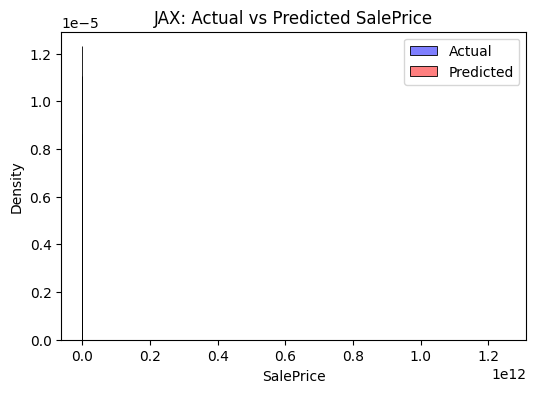

In [25]:
preds_val_log = model_jax.apply({'params': state_jax.params}, jnp.array(X_val_scaled), training=False, rngs={'dropout': rng_jax})
preds_val_log = np.array(preds_val_log).flatten()
print("Any NaNs in JAX predictions?", np.any(np.isnan(preds_val_log)))

# Convert predictions back to original scale
y_val_pred_jax = np.exp(preds_val_log)
y_val_actual_jax = np.exp(y_val.values.flatten())
rmse_jax_final = np.sqrt(mean_squared_error(y_val_actual_jax, y_val_pred_jax))
print('JAX Validation RMSE:', rmse_jax_final)

# Plot distribution histograms for JAX
plt.figure(figsize=(6,4))
sns.histplot(y_val_actual_jax, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(y_val_pred_jax, bins=50, color='red', alpha=0.5, stat='density', label='Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('JAX: Actual vs Predicted SalePrice')
plt.legend()
plt.show()

In [26]:
# --- JAX Prediction Saving Cell ---
# Preprocess test data as for training
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)
test_jax = jnp.array(test_scaled)

# Get predictions from the JAX model (on log scale)
preds_jax_log = model_jax.apply({'params': state_jax.params}, test_jax, training=False, rngs={'dropout': rng_jax})
preds_jax_log = np.array(preds_jax_log).flatten()

# Convert predictions back to original scale
preds_jax = np.exp(preds_jax_log)

# Save predictions
predictions_jax = pd.DataFrame({'ID': test_ids, 'SALEPRICE': preds_jax})
predictions_jax.to_csv('predictions_jax_KL.csv', index=False)
print("JAX predictions saved to predictions_jax_KL.csv")


JAX predictions saved to predictions_jax_KL.csv


/tmp/ipykernel_10382/2818284174.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_10382/2818284174.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

## 5. Combined Summary and Comparison
Here we summarize and compare performance metrics (RMSE) and plot combined loss curves and distribution histograms for the three frameworks.

Keras RMSE: 431797.7582114109
PyTorch RMSE: 5861882.968990766
JAX RMSE: 88882487720.05888


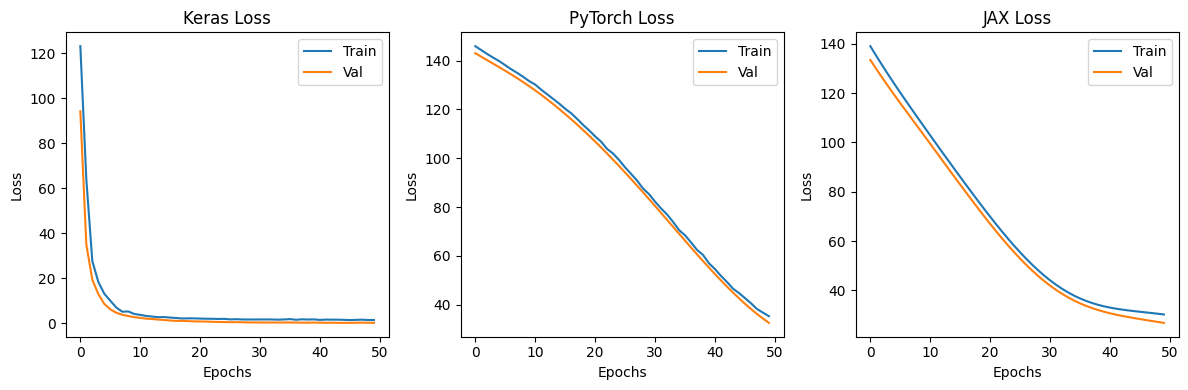

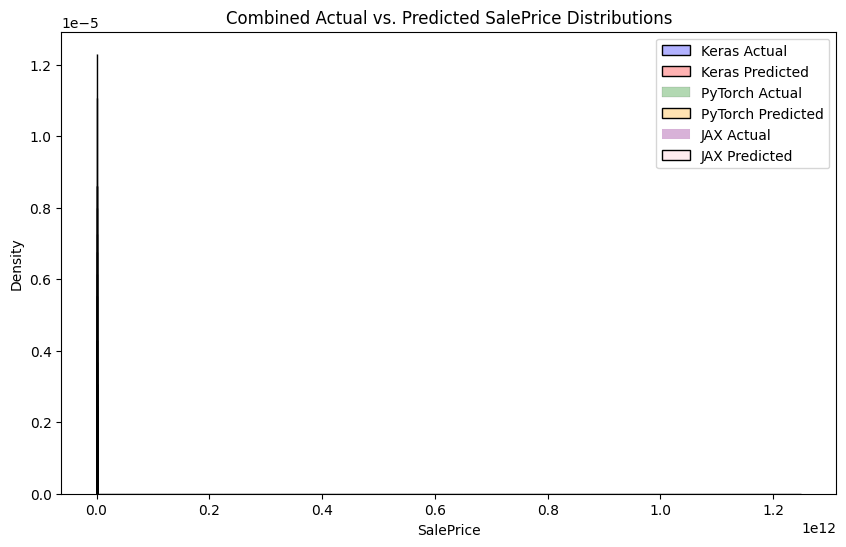

In [27]:
# Summary RMSE values
print("Keras RMSE:", rmse_keras)
print("PyTorch RMSE:", rmse_torch)
print("JAX RMSE:", rmse_jax_final)

# Combined loss curves (if desired, you can plot them side-by-side)
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(history_keras.history['loss'], label='Train')
plt.plot(history_keras.history['val_loss'], label='Val')
plt.title('Keras Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_losses_pt, label='Train')
plt.plot(val_losses_pt, label='Val')
plt.title('PyTorch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_losses_jax, label='Train')
plt.plot(val_losses_jax, label='Val')
plt.title('JAX Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Combined distribution histogram: overlay actual vs. predicted for all methods
plt.figure(figsize=(10,6))
sns.histplot(y_val_actual, bins=50, color='blue', alpha=0.3, stat='density', label='Keras Actual')
sns.histplot(np.exp(y_val_pred_log), bins=50, color='red', alpha=0.3, stat='density', label='Keras Predicted')

sns.histplot(y_val_actual_pt, bins=50, color='green', alpha=0.3, stat='density', label='PyTorch Actual')
sns.histplot(val_preds_pt, bins=50, color='orange', alpha=0.3, stat='density', label='PyTorch Predicted')

sns.histplot(y_val_actual_jax, bins=50, color='purple', alpha=0.3, stat='density', label='JAX Actual')
sns.histplot(y_val_pred_jax, bins=50, color='pink', alpha=0.3, stat='density', label='JAX Predicted')

plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Actual vs. Predicted SalePrice Distributions')
plt.legend()
plt.show()

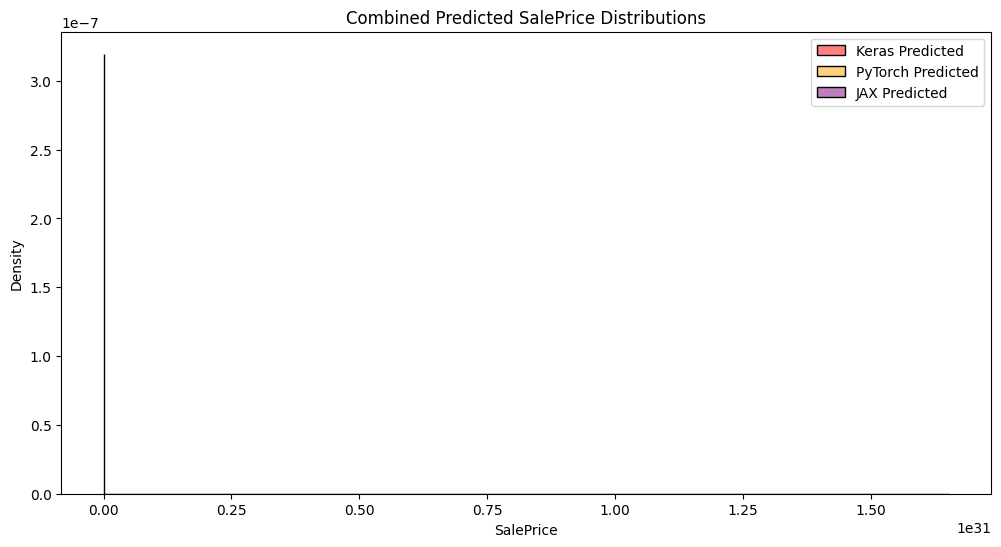

In [28]:
# Load the saved predictions (assuming the files are in the working directory)
pred_keras = pd.read_csv('predictions_keras_KL.csv')
pred_torch = pd.read_csv('predictions_pytorch_KL.csv')
pred_jax = pd.read_csv('predictions_jax_KL.csv')

# For comparison, load the actual SalePrice from train.csv (or use a held-out validation set if available)
# Here we assume y_val_actual (computed as np.exp(y_val)) is available from the Keras evaluation cell.
# Otherwise, adjust to use your validation set actual values.

plt.figure(figsize=(12, 6))

# Plot histograms for Keras predictions
sns.histplot(pred_keras['SALEPRICE'], bins=50, color='red', alpha=0.5, stat='density', label='Keras Predicted')

# Plot histograms for PyTorch predictions
sns.histplot(pred_torch['SALEPRICE'], bins=50, color='orange', alpha=0.5, stat='density', label='PyTorch Predicted')

# Plot histograms for JAX predictions
sns.histplot(pred_jax['SALEPRICE'], bins=50, color='purple', alpha=0.5, stat='density', label='JAX Predicted')

# If you have actual test SalePrice distribution, overlay that too (or use your validation set)
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Predicted SalePrice Distributions')
plt.legend()
plt.show()


The significant differences in RMSE suggest that the PyTorch and JAX models aren’t converging as expected compared to the Keras model. In our combined loss setup (MSE + KL divergence on log‑transformed targets), instability in the KL term is a common culprit. Here are several troubleshooting suggestions and potential modifications:

Isolate the Problem (Use Only MSE):
Temporarily train the PyTorch and JAX models using only MSE loss (set the KL weight α = 0). If RMSE values drop dramatically, it confirms that the KL divergence penalty is causing instability.

Reduce the KL Weight Further:
Even α = 0.001 might be too high for PyTorch and JAX. Try reducing it further (for example, 1e-4 or even 0 for debugging) to see if that stabilizes training.

Verify Consistent Log Transformation:
Ensure that all frameworks are:

Using log(SalePrice) as the target during training.
Exponentiating the predictions for RMSE calculation. Check that your data pipeline (train/val split, scaling, feature selection) is identical across frameworks.
Examine the KL Term Implementation:
Differences in the implementation of the soft histogram and KL divergence function between frameworks could cause instability. Add debugging printouts (or use a debugger) to inspect the intermediate histogram values and KL loss. Verify that the values are reasonable (i.e. histograms should sum to 1 and not contain extreme values).

Learning Rate and Weight Initialization:
Even slight differences in learning rate or weight initialization can affect convergence. Verify that all frameworks use a similar learning rate (e.g. 0.001) and, if possible, try to set seeds so that initializations are as consistent as possible.

Training Duration:
It might be that the Keras model converges faster (or the combined loss is weighted differently by its optimizer) compared to PyTorch and JAX. Try training all models for a longer duration and monitor the loss curves.